Construirá una red convolucional muy profunda, utilizando redes residuales (ResNets). En teoría, las redes muy profundas pueden representar funciones muy complejas; pero en la práctica, son difíciles de entrenar. Las redes residuales, presentadas por [He et al.](https://arxiv.org/pdf/1512.03385.pdf), le permiten entrenar redes mucho más profundas de lo que antes era factible.

### El problema de las redes neuronales muy profundas

En los últimos años, las redes neuronales se han vuelto mucho más profundas, con redes de última generación que han pasado de tener solo unas pocas capas (por ejemplo, AlexNet) a más de cien capas.

* Sin embargo, usar una red más profunda no siempre ayuda. Una gran barrera para entrenarlos son los gradientes que se desvanecen: las redes muy profundas a menudo tienen una señal de gradiente que llega a cero rápidamente, lo que hace que el descenso de gradiente sea prohibitivamente lento.

* Más específicamente, durante el descenso del gradiente, a medida que retropropaga de la capa final a la primera capa, está multiplicando por la matriz de peso en cada paso y, por lo tanto, el gradiente puede disminuir exponencialmente rápidamente hasta cero (o, en casos raros, crecer exponencialmente rápido y "explotar", al ganar valores muy grandes).



# Construyendo una Residual Network

En ResNet, un "shortcut" o un "skip connection" permite al modelo omitir capas:

<img src="images/skip_connection_kiank.png" style="width:650px;height:200px;">

La imagen de la derecha agrega un acceso directo a la ruta principal. Al apilar estos bloques ResNet uno encima del otro, puede formar una red muy profunda.

Tener bloques ResNet con el shortcut también hace que sea muy fácil para uno de los bloques aprender una función de identidad. Esto significa que puede apilar bloques ResNet adicionales con poco riesgo de dañar el rendimiento del conjunto de entrenamiento.

En ese sentido, también hay alguna evidencia de que la facilidad de aprender una función de identidad explica el notable rendimiento de ResNets incluso más que las skip connections que ayudan con los vanishing gradients.


Se utilizan **dos tipos principales de bloques en una ResNet**, dependiendo principalmente de si las dimensiones de entrada/salida son iguales o diferentes. 
Se implementará ambos: el `"identity block"` y el `"convolutional block."`

In [100]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Input, Dense, Add, Activation, BatchNormalization, Flatten, Conv2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D, GlobalMaxPooling2D
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.initializers import RandomUniform, GlorotUniform, Identity, Constant
from PIL import Image
from resnets_utils import load_dataset, drive_download


ImportError: cannot import name 'drive_download' from 'resnets_utils' (c:\Users\sandr\Desktop\Portafolio\ResNet50 - SIGNS_Classification\resnets_utils.py)

## 1. The Identity block

El bloque de identidad es el bloque estándar utilizado en ResNets y corresponde al caso en el que la activación de entrada (por ejemplo, $a^{[l]}$) tiene **la misma dimensión que la activación de salida** (por ejemplo, $a^{ [l+2]}$).

<img src="images/idblock2_kiank.png" style="width:650px;height:150px;">
<caption><center> La Skip connection "Omite sobre" 2 capas. </center></caption>

**Para acelerar el entrenamiento, se ha agregado un paso BatchNorm**. 



En este ejercicio, implementará una versión un poco más poderosa de este bloque de identidad, en la que la skip connection "salta" 3 capas ocultas en lugar de 2 capas. Se parece a esto:

<img src="images/idblock3_kiank.png" style="width:650px;height:150px;">
    <caption><center>Skip connection "Omite sobre" 3 capas.</center></caption>

Estos son los pasos individuales:

Primer componente de la ruta principal:
- El primer CONV2D tiene $F_1$ filtros de forma (1,1) y un paso de (1,1). Su padding es "valid". Use 0 como semilla para la inicialización aleatoria uniforme: `kernel_initializer = initializer(seed=0)`.
- El primer BatchNorm está normalizando el eje de 'channels'.
- Luego aplique la función de activación de ReLU. Esto no tiene hiperparámetros.

Segundo componente de la ruta principal:
- El segundo CONV2D tiene $F_2$ filtros de forma $(f,f)$ y un paso de (1,1). Su padding es "same". Use 0 como semilla para la inicialización aleatoria uniforme: `kernel_initializer = initializer(seed=0)`.
- El segundo BatchNorm está normalizando el eje de 'channels'.
- Luego aplique la función de activación de ReLU. Esto no tiene hiperparámetros.

Tercer componente de la ruta principal:
- El tercer CONV2D tiene $F_3$ filtros de forma (1,1) y un paso de (1,1). Su padding es "valid". Use 0 como semilla para la inicialización aleatoria uniforme: `kernel_initializer = initializer(seed=0)`.
- El tercer BatchNorm está normalizando el eje de 'channels'.
- Tenga en cuenta que **no** hay función de activación de ReLU en este componente.

Último paso:
- El `X_shortcut` y la salida de la tercera capa `X` se suman.
- **Sugerencia**: La sintaxis se parecerá a `Add()([var1,var2])`
- Luego aplique la función de activación de ReLU. Esto no tiene hiperparámetros.

In [4]:
def identity_block(X, f, filters, training=True, initializer = RandomUniform):
    # X: entrada, y tambien alimenta a la ultima capa (m, n_H_prev, n_W_prev, n_C_prev)
    # f : int, especificando la forma de la ventana central de CONV para la ruta principal
    # filters : Cantidad de filtros aplicados
    # initializer : Inicializador de entradas
    # training -- True: Comportarse en modo entrenamiento
    #          -- False: Comportarse en modo de inferencia
    F1,F2,F3 = filters

    X_shortcut = X

    # 1ra componente de la ruta principal
    X = Conv2D(filters = F1, kernel_size = 1, strides = 1, padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = -1)(X, training = training)
    X = Activation('relu')(X)

    # 2da componente de la ruta principal
    X = Conv2D(filters = F2, kernel_size = f, strides = 1, padding = 'same', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = -1)(X, training = training)
    X = Activation('relu')(X)

    # 3ra componente de la ruta principal
    X = Conv2D(filters = F3, kernel_size = 1, strides = 1, padding = "valid", kernel_initializer = initializer(seed = 0))(X)
    X = BatchNormalization(axis = -1)(X, training = training)

    # Paso final: Agregar el valor del shortcut a la ruta principal
    X = Add()([X_shortcut, X])
    X = Activation('relu')(X)
    
    return X

## 2. The Convolutional Block

El **Bloque convolucional** de ResNet es el segundo tipo de bloque. Puede usar este tipo de bloque cuando **las dimensiones de entrada y salida no coinciden**. La diferencia con el bloque de identidad es que hay una capa CONV2D en la ruta del shortcut:

<img src="images/convblock_kiank.png" style="width:650px;height:150px;">

* La capa CONV2D en la ruta del shortcut se usa para cambiar el tamaño de la entrada $x$ a una dimensión diferente, de modo que las dimensiones coincidan en la adición final necesaria para agregar el valor del shorcut nuevamente a la ruta principal.
* Por ejemplo, para reducir la altura y el ancho de las dimensiones de activación en un factor de 2, puede usar una convolución de 1x1 con un stride de 2.
* La capa CONV2D en la ruta del shortcut no utiliza ninguna función de activación no lineal. Su función principal es simplemente aplicar una función lineal (aprendida) que reduce la dimensión de la entrada, de modo que las dimensiones coincidan para el paso de adición posterior.

Los detalles del bloque convolucional son los siguientes.

Primer componente de la ruta principal:
- El primer CONV2D tiene $F_1$ filtros de forma (1,1) y un paso de (s,s). Su padding es "valid". Use 0 como la semilla `glorot_uniform` `kernel_initializer = initializer(seed=0)`.
- El primer BatchNorm está normalizando el eje de 'channels'.
- Luego aplique la función de activación de ReLU. Esto no tiene hiperparámetros.

Segundo componente de la ruta principal:
- El segundo CONV2D tiene $F_2$ filtros de forma (f,f) y un paso de (1,1). Su padding es "same". Use 0 como la semilla `glorot_uniform` `kernel_initializer = initializer(seed=0)`.
- El segundo BatchNorm está normalizando el eje de 'channels'.
- Luego aplique la función de activación de ReLU. Esto no tiene hiperparámetros.

Tercer componente de la ruta principal:
- El tercer CONV2D tiene $F_3$ filtros de forma (1,1) y un paso de (1,1). Su padding es "valid". Use 0 como la semilla `glorot_uniform` `kernel_initializer = initializer(seed=0)`.
- El tercer BatchNorm está normalizando el eje de 'channels'. Tenga en cuenta que no hay una función de activación de ReLU en este componente.

Ruta del shortcut:
- El CONV2D tiene $F_3$ filtros de forma (1,1) y un paso de (s,s). Su relleno es "valid". Use 0 como la semilla `glorot_uniform` `kernel_initializer = initializer(seed=0)`.
- El BatchNorm está normalizando el eje de 'channels'.

Último paso:
- El shortcut y los valores de la ruta principal se suman juntos.
- Luego aplique la función de activación de ReLU. Esto no tiene hiperparámetros.

In [17]:
def convolutional_block(X, f, filters, s=2, training=True, initializer=GlorotUniform):
    # X: entrada, y tambien alimenta a la ultima capa (m, n_H_prev, n_W_prev, n_C_prev)
    # f : int, especificando la forma de la ventana central de CONV para la ruta principal
    # filters : Cantidad de filtros aplicados
    # initializer : Inicializador de los parametros
    #     training -- True: Comportarse en modo entrenamiento
    #              -- False: Comportarse en modo de inferencia
    
    F1, F2, F3 = filters
    X_shortcut = X

    # 1ra componente de la ruta principal
    X = Conv2D(filters = F1, kernel_size = 1, strides = s, padding='valid', kernel_initializer=initializer(seed=0))(X)
    X = BatchNormalization(axis=-1)(X, training=training)
    X = Activation('relu')(X)

    # 2da componente de la ruta principal
    X = Conv2D(filters=F2, kernel_size = f, strides = 1, padding = 'same', kernel_initializer=initializer(seed=0))(X)
    X = BatchNormalization(axis=-1)(X, training=training)
    X = Activation('relu')(X)

    # 3ra componente de la ruta principal
    X = Conv2D(filters = F3, kernel_size = 1, strides = 1, padding = 'valid', kernel_initializer=initializer(seed=0))(X)
    X = BatchNormalization(axis = -1)(X, training = training)

    # Ruta del shortcut
    X_shortcut = Conv2D(filters = F3, kernel_size = 1, strides = s, padding = 'valid', kernel_initializer=initializer(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = -1)(X_shortcut, training = training)

    # Paso final: Agregue valor del shortcut a la ruta principal (Use este orden [X, X_shortcut]) y páselo a través de una activación RELU
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

## 3. Creación de su primer modelo ResNet (50 capas)

Ahora tiene los bloques necesarios para construir una ResNet muy profunda. La siguiente figura describe en detalle la arquitectura de esta red neuronal. "ID BLOCK" en el diagrama significa "Identity block" y "ID BLOCK x3" significa que debe apilar 3 bloques de identidad juntos.

<img src="images/resnet_kiank.png" style="width:850px;height:150px;">
<caption><center> <b>ResNet-50 model</b> </center></caption>


Los detalles de este modelo ResNet-50 son:
- El Zero-padding rellena la entrada con un relleno de (3,3)
- Stage 1:
    - La convolución 2D tiene 64 filtros de forma (7,7) y utiliza un paso de (2,2).
    - BatchNorm se aplica al eje de 'channels' de la entrada.
    - MaxPooling utiliza una ventana (3,3) y un paso (2,2).
- Stage 2:
    - El bloque convolucional utiliza tres conjuntos de filtros de tamaño [64,64,256], "f" es 3 y "s" es 1.
    - Los 2 bloques de identidad usan tres conjuntos de filtros de tamaño [64,64,256], y "f" es 3.
- Stage 3:
    - El bloque convolucional utiliza tres conjuntos de filtros de tamaño [128,128,512], "f" es 3 y "s" es 2.
    - Los 3 bloques de identidad usan tres conjuntos de filtros de tamaño [128,128,512] y "f" es 3.
- Stage 4:
    - El bloque convolucional utiliza tres conjuntos de filtros de tamaño [256, 256, 1024], "f" es 3 y "s" es 2.
    - Los 5 bloques de identidad utilizan tres conjuntos de filtros de tamaño [256, 256, 1024] y "f" es 3.
- Etapa 5:
    - El bloque convolucional utiliza tres conjuntos de filtros de tamaño [512, 512, 2048], "f" es 3 y "s" es 2.
    - Los 2 bloques de identidad usan tres conjuntos de filtros de tamaño [512, 512, 2048] y "f" es 3.
- El AveragePooling 2D utiliza una ventana de forma (2,2).
- La capa 'Flatten' no tiene hiperparámetros.
- La capa Totalmente Conectada (Densa) reduce su entrada al número de clases usando una activación softmax.

In [18]:
def ResNet50(input_shape = (64,64,3), classes=6):
    '''
    Argumentos:
     input_shape -- forma de las imágenes del conjunto de datos
     clases -- número entero, número de clases

     Devoluciones:
     model -- una instancia de Model() en Keras
    '''
    X_input = Input(input_shape)

    # Zero-padding
    X = ZeroPadding2D((3,3))(X_input)

    # Stage 1
    X = Conv2D(64, kernel_size = 7, strides = 2, kernel_initializer = GlorotUniform(seed = 0))(X)
    X = BatchNormalization(axis = -1)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D(pool_size = 3, strides = 2)(X)

    # Stage 2
    X = convolutional_block(X, 3, [64,64,256], s=1)
    X = identity_block(X, 3, [64,64,256])
    X = identity_block(X, 3, [64,64,256])

    # Stage 3
    X = convolutional_block(X, 3, [128,128,512], s=2)
    X = identity_block(X, 3, [128,128,512])
    X = identity_block(X, 3, [128,128,512])
    X = identity_block(X, 3, [128,128,512])

    # Stage 4
    X = convolutional_block(X, 3, [256, 256, 1024], s=2)
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])

    # Stage 5
    X = convolutional_block(X, 3, [512, 512, 2048], s=2)
    X = identity_block(X, 3, [512, 512, 2048])
    X = identity_block(X, 3, [512, 512, 2048])

    # Paso final
    X = AveragePooling2D(pool_size = 2)(X)
    X = Flatten()(X)
    X = Dense(classes, activation = 'softmax', kernel_initializer=GlorotUniform(seed=0))(X)

    # Creamos el modelo
    model = Model(inputs = X_input, outputs = X)

    return model



In [31]:
tf.keras.backend.clear_session()
model = ResNet50(input_shape = (64,64,3), classes = 6)

In [33]:
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 70, 70, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 64)   9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 64)   256         conv2d[0][0]                     
______________________________________________________________________________________________

In [34]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

El modelo ahora está listo para ser entrenado. ¡Lo único que necesita ahora es un conjunto de datos!

Carguemos el conjunto de datos SIGNS.

<img src="images/signs_data_kiank.png" style="width:450px;height:250px;">

In [43]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = ru.load_dataset()

In [51]:
# Normalizamos imagenes
X_train = X_train_orig/255.
X_test = X_test_orig/255.

# Convertimos las target de training y test a matrices one-hot
Y_train = tf.one_hot(Y_train_orig.reshape(-1), 6).numpy()
Y_test = tf.one_hot(Y_test_orig.reshape(-1), 6).numpy()

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


Ejecute la siguiente celda para entrenar su modelo en 2 épocas con un tamaño de lote de 32. En una CPU, le llevará alrededor de 5 minutos por época.

In [62]:
history = model.fit(X_train, Y_train, epochs = 2, batch_size = 32)

Epoch 1/2
34/34 [==============================] - 122s 4s/step - loss: 0.2866 - accuracy: 0.9083
Epoch 2/2
34/34 [==============================] - 125s 4s/step - loss: 0.1602 - accuracy: 0.9380


Veamos cómo se comporta este modelo (entrenado en solo dos épocas) en el conjunto de prueba.

In [61]:
ev = model.evaluate(X_test, Y_test)
print ("Loss = " + str(ev[0]))
print ("Test Accuracy = " + str(ev[1]))

4/4 [==============================] - 2s 482ms/step - loss: 0.8463 - accuracy: 0.7250
Loss = 0.8463267087936401
Test Accuracy = 0.7250000238418579


In [70]:
pd.DataFrame(history.history)

,loss,accuracy
0,0.286559,0.908333
1,0.160234,0.937963


A los efectos de esta tarea, le hemos pedido que entrene el modelo durante solo dos épocas. Se puede ver que logra rendimientos pobres, si lo desea. Obtenemos un rendimiento mucho mejor cuando entrenamos durante ~20 épocas, pero esto tomará más de una hora cuando entrenamos en una CPU.

Usando una GPU, hemos entrenado los pesos de nuestro propio modelo ResNet50 en el conjunto de datos de SIGNS. Puede cargar y ejecutar nuestro modelo entrenado en el conjunto de prueba en las celdas a continuación. Puede tardar ≈1 min en cargar el modelo.

[Descarga](https://drive.google.com/file/d/1GeVMC2f3jf0uufR3FP2u1qDUWw1i-F54/view?usp=sharing) , URL del modelo entrenado con GPU

In [92]:
model = load_model('ResNet50.h5')

In [93]:
ev = model.evaluate(X_test, Y_test)
print ("Loss = " + str(ev[0]))
print ("Test Accuracy = " + str(ev[1]))

4/4 [==============================] - 7s 496ms/step - loss: 0.5302 - accuracy: 0.8667
Loss = 0.5301783680915833
Test Accuracy = 0.8666666746139526


***Prueba en tu propia imagen***

In [63]:
import cv2

In [94]:
img_path = 'images/my_image.jpg'
img = Image.open(img_path)
img_resize = cv2.resize(np.array(img), (64, 64), interpolation =  cv2.INTER_CUBIC).reshape(1,64,64,3)
x = img_resize/255.
print("class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] = ")
y = model.predict(x)
print(y)

class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] = 
[[3.5465923e-06 2.8655684e-04 9.9951088e-01 2.0490866e-07 1.9831577e-04
  4.2891079e-07]]


La imagen dio como predicción  2


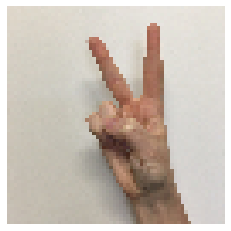

In [95]:
print("La imagen dio como predicción ", y.argmax())
plt.imshow(x[0])
plt.axis("off")
plt.show();